In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
from pandas.io import sql
import sqlite3

## Step 1. Data imports and exploratory analysis

In [2]:
df = pd.read_csv("/Users/benstan/Documents/Job Search 2016/lyft_case/lyft_data_1.csv")

In [3]:
df.head()

,driver_id,donation amount,unix timestamp
0,0,12,978307000
1,0,12,978566000
2,0,12,978566000
3,0,13,978739000
4,0,13,978480000


In [4]:
df['date'] = pd.to_datetime(df['unix timestamp'],unit='s',format='%Y-%m-%d').astype(str).str.slice(0,10)#.substr
df['timestamp'] = pd.to_datetime(df['unix timestamp'],unit='s',format='%Y-%m-%d')
df['donation_amount'] = df['donation amount']

In [5]:
del df['donation amount']
del df['unix timestamp']

In [6]:
df.head()

,driver_id,date,timestamp,donation_amount
0,0,2000-12-31,2000-12-31 23:56:40,12
1,0,2001-01-03,2001-01-03 23:53:20,12
2,0,2001-01-03,2001-01-03 23:53:20,12
3,0,2001-01-05,2001-01-05 23:56:40,13
4,0,2001-01-03,2001-01-03 00:00:00,13


In [7]:
print "number of rides:",len(df)
print "number of drivers:",len(np.unique(df.driver_id))
print "min date:",df['date'].min()
print "max date:",df['date'].max()
#84 days of data in dataset

number of rides: 44637
number of drivers: 98
min date: 2000-12-31
max date: 2001-03-24


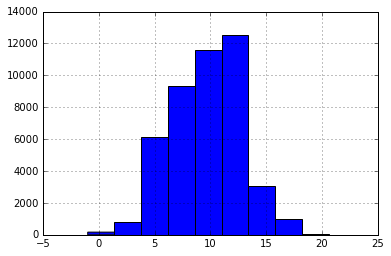

In [8]:
df['donation_amount'].hist() #Plot of fare prices

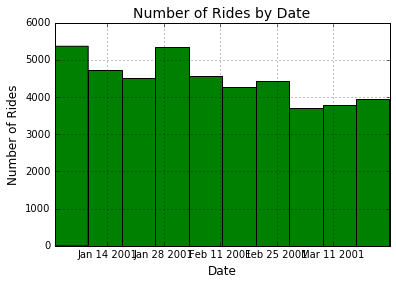

In [9]:
fig = plt.figure()
df['timestamp'].hist(color='green')
plt.title('Number of Rides by Date', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)

### Number of rides realtively consistent over period of interest

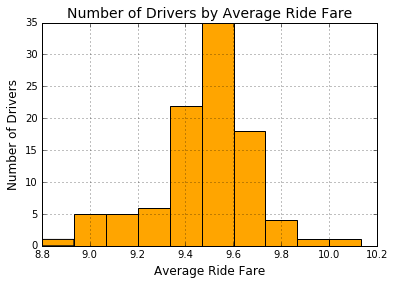

In [10]:
fig = plt.figure()
df[['driver_id','donation_amount']].groupby('driver_id').mean().hist(color='orange') #histogram of average ride amount by driver
plt.title('Number of Drivers by Average Ride Fare', fontsize=14)
plt.xlabel('Average Ride Fare', fontsize=12)
plt.ylabel('Number of Drivers', fontsize=12)

### Average ride fare by driver appears to be normally distributed with mean of $9.50

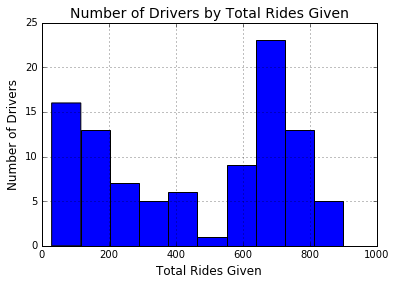

In [11]:
#num_rides = df[['driver_id','donation_amount']].groupby('driver_id').count().hist()
fig = plt.figure()
df[['driver_id','donation_amount']].groupby('driver_id').count().hist()
plt.title('Number of Drivers by Total Rides Given', fontsize=14)
plt.xlabel('Total Rides Given', fontsize=12)
plt.ylabel('Number of Drivers', fontsize=12)

### Two groups of drivers shown: Lighter and heavier

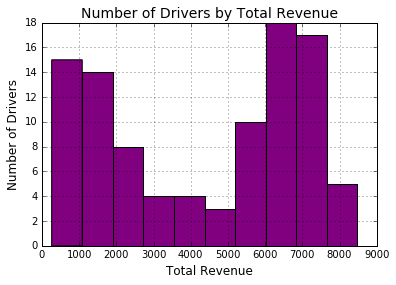

In [12]:
fig = plt.figure()
df[['driver_id','donation_amount']].groupby('driver_id').sum().hist(color='purple')
plt.title('Number of Drivers by Total Revenue', fontsize=14)
plt.xlabel('Total Revenue', fontsize=12)
plt.ylabel('Number of Drivers', fontsize=12)

### Revenue shows similar distribution to total number of rides, which is expected given that each driver's average fare is roughly the same

## Step 2. Investigate differences in total rides given

In [13]:
print df[['driver_id','timestamp']].groupby('driver_id').count().min() 
print df[['driver_id','timestamp']].groupby('driver_id').count().max()

timestamp    29
dtype: int64
timestamp    900
dtype: int64


### Minimum number of rides is 29; max is 900

In [14]:
conn = sqlite3.connect('df.db', detect_types=sqlite3.PARSE_DECLTYPES)
df.to_sql('df',
            con=conn,
            if_exists='replace',
            index=False)

In [15]:
driver_date_range=sql.read_sql("""
SELECT
driver_id,
min(date) AS first_ride_date,
max(date) AS last_ride_date,
julianday(max(date)) - julianday(min(date)) AS days_driving 

FROM
df

GROUP BY 1
""", con=conn)

In [16]:
rides_per_day=sql.read_sql("""
SELECT
driver_id,
COUNT(date) AS num_days,
SUM(num_rides) AS total_rides

FROM

(SELECT
driver_id,
date,
COUNT(donation_amount) AS num_rides

FROM
df

GROUP BY 1,2)
GROUP BY 1
""", con=conn)
rides_per_day['rides_day'] = rides_per_day['total_rides'].astype(float)/rides_per_day['num_days'].astype(float)

### Total rides given can be broken down into two factors: number of days driving and number of rides given per day

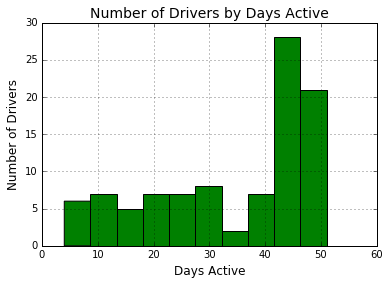

In [17]:
fig = plt.figure()
rides_per_day['num_days'].hist(color='green')
plt.title('Number of Drivers by Days Active', fontsize=14)
plt.xlabel('Days Active', fontsize=12)
plt.ylabel('Number of Drivers', fontsize=12)

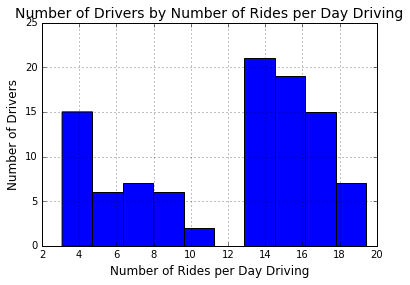

In [18]:
fig = plt.figure()
rides_per_day['rides_day'].hist()
plt.title('Number of Drivers by Number of Rides per Day Driving', fontsize=14)
plt.xlabel('Number of Rides per Day Driving', fontsize=12)
plt.ylabel('Number of Drivers', fontsize=12)

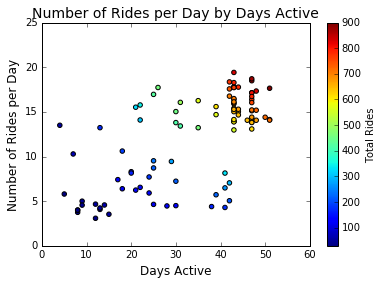

In [19]:
fig = plt.figure()
plt.scatter(rides_per_day['num_days'],rides_per_day['rides_day'],c=rides_per_day['total_rides'])
cb = plt.colorbar()
cb.set_label("Total Rides")
plt.title('Number of Rides per Day by Days Active', fontsize=14)
plt.xlabel('Days Active', fontsize=12)
plt.ylabel('Number of Rides per Day', fontsize=12)

### By looking at the scatterplot, the y axis, or Number of Rides per Day, appears to be the differentiating factor

## Step 3. Look at customer churn in order to calculate lifetime value

In [20]:
print df[['driver_id','date']].groupby('driver_id').min().reset_index()['date'].value_counts().sort_index()
#df[['driver_id','timestamp']].groupby('driver_id').min().reset_index()['timestamp'].hist(color='orange')

2000-12-31    76
2001-01-02     2
2001-01-08    14
2001-01-15     6
Name: date, dtype: int64


### The first ride for all drivers took place on one of four dates, all within the first ~2 weeks of the time period of interest

In [21]:
print df[['driver_id','date']].groupby('driver_id').max().reset_index()['date'].value_counts().sort_index()

2001-01-07     1
2001-01-13     2
2001-01-20     4
2001-01-28     5
2001-02-04     4
2001-02-11     2
2001-02-17     7
2001-02-24     9
2001-03-03     1
2001-03-04     6
2001-03-11     2
2001-03-18    10
2001-03-24    45
Name: date, dtype: int64


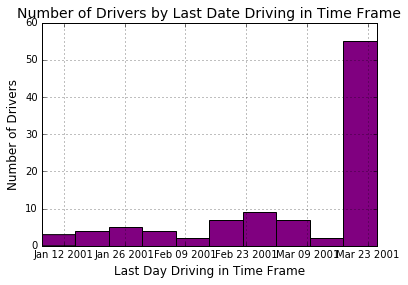

In [22]:
fig = plt.figure()
df[['driver_id','timestamp']].groupby('driver_id').max().reset_index()['timestamp'].hist(color='purple')
plt.title('Number of Drivers by Last Date Driving in Time Frame', fontsize=14)
plt.xlabel('Last Day Driving in Time Frame', fontsize=12)
plt.ylabel('Number of Drivers', fontsize=12)

### The last ride for drivers took place at various times, with many remaining active until the end of the time period

In [23]:
survivor_group=sql.read_sql("""
SELECT
COUNT(driver_id) AS total_drivers,
SUM(CASE WHEN last_ride_date >= '2001-03-11' THEN 1 ELSE 0 END) AS num_active_end

FROM

(SELECT
driver_id,
min(date) AS first_ride_date,
max(date) AS last_ride_date,
julianday(max(date)) - julianday(min(date)) AS days_driving 

FROM
df

GROUP BY 1)
""", con=conn)
survivor_group

,total_drivers,num_active_end
0,98,57


### About 60% of drivers who were active at the start of the period were active at the end; this equates to a 40% churn rate over the period of interest (roughly 3 months). Assuming constant churn rate, this can be represented by y=0.6^x

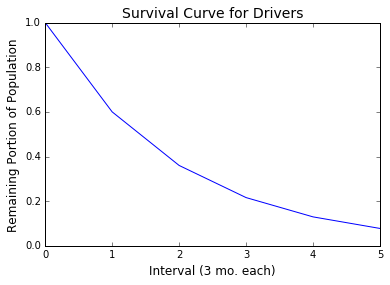

In [24]:
x=np.arange(6)
y=0.6**(x)
fig = plt.figure()
plt.plot(x,y)
plt.title('Survival Curve for Drivers', fontsize=14)
plt.xlabel('Interval (3 mo. each)', fontsize=12)
plt.ylabel('Remaining Portion of Population', fontsize=12)

In [25]:
average_revenue_driver=sql.read_sql("""
SELECT
AVG(total_revenue_driver) AS avg_revenue

FROM

(SELECT
driver_id,
SUM(donation_amount) AS total_revenue_driver

FROM
df

GROUP BY 1)
""", con=conn)
average_revenue_driver

,avg_revenue
0,4328.387755


### Average revenue per driver over time period is $4328

## Step 4. Apply driver type learnings to CLV

In [26]:
rides_per_day['driver_type'] = 'light'
heavy_mask = rides_per_day['rides_day'] >= 12
rides_per_day.loc[heavy_mask,'driver_type'] = 'heavy'

In [30]:
driver_types = rides_per_day[['driver_id','driver_type']]

In [34]:
df = pd.merge(df,driver_types,on='driver_id')

In [35]:
conn = sqlite3.connect('df.db', detect_types=sqlite3.PARSE_DECLTYPES)
df.to_sql('df',
            con=conn,
            if_exists='replace',
            index=False)

In [36]:
survivor_group_split=sql.read_sql("""
SELECT
driver_type,
COUNT(driver_id) AS total_drivers,
SUM(CASE WHEN last_ride_date >= '2001-03-11' THEN 1 ELSE 0 END) AS num_active_end

FROM

(SELECT
driver_id,
driver_type,
min(date) AS first_ride_date,
max(date) AS last_ride_date,
julianday(max(date)) - julianday(min(date)) AS days_driving 

FROM
df

GROUP BY 1,2)
GROUP BY 1
""", con=conn)
survivor_group_split

,driver_type,total_drivers,num_active_end
0,heavy,62,50
1,light,36,7


### Light drivers have much higher churn rates!

In [37]:
average_revenue_driver_split=sql.read_sql("""
SELECT
driver_type,
AVG(total_revenue_driver) AS avg_revenue

FROM

(SELECT
driver_id,
driver_type,
SUM(donation_amount) AS total_revenue_driver

FROM
df

GROUP BY 1,2)
GROUP BY 1
""", con=conn)
average_revenue_driver_split

,driver_type,avg_revenue
0,heavy,6086.016129
1,light,1301.361111


### These values can be used to compute separate CLVs for the driver cohorts